In [1]:
from AMMD_functions import *

###### Non-TSP data #####

c_elegans = "datasets/weighted_digraphs/celegansneural_weighted.txt"
moreno_health = "datasets/weighted_digraphs/moreno_health_weighted.txt"
wiki_vote_snap = "datasets/weighted_digraphs/Wiki-Vote.txt"
gnutella_snap = "datasets/weighted_digraphs/Gnutella_snap.txt"
bitcoin = 'datasets/weighted_digraphs/bitcoin.txt'
airport = 'datasets/weighted_digraphs/airport.txt'
openflight = 'datasets/weighted_digraphs/openflight.txt'
cora = 'datasets/weighted_digraphs/cora.txt'

ft70 = 'datasets/ALL_atsp/ft70.atsp'
kro124 = 'datasets/ALL_atsp/kro124p.atsp'
rbg323 = 'datasets/ALL_atsp/rbg323.atsp'

In [2]:
from IPython.display import display, Latex

from datetime import timedelta
import re

def read_results_file(results_filename, add_optimals_manually=True, optimal_values=None):
    with open(results_filename, "r") as f:
        text = f.read()

    sections = text.split('**************')[:-1]
    results = []

    for section in sections:
        # Split the section into lines
        lines = section.strip().split('\n')

        # The dataset name is on the first line
        dataset = lines[0].strip().split('.')[0].split('/')[-1].split('_')[0]

        # The scores are on the last line, inside brackets
        # We need to remove the brackets, split by spaces, and convert to floats or integers
        scores = lines[-1].strip('[] ').split(', ')
        scores = [int(float(score)) if float(score).is_integer() else float(score) for score in scores]

        # Extract the algorithm names
        algorithm_names = [line.split(' done:')[0] for line in lines if ' done:' in line]
        
        # Extract the running times
        times = [re.search('0:[0-9:]+.[0-9]*', line).group() for line in lines if ' done:' in line]
        
        # Convert the time strings to datetime objects, round them, and convert them back to strings
        times = [str((datetime.strptime(time, '%H:%M:%S.%f') + timedelta(milliseconds=500)).time()) for time in times]

        # Add the dataset name, scores, and times to the results
        results.append((dataset, scores, times))

    if add_optimals_manually:
        # Include the predefined optimal scores
        algorithm_names.append("Opt.")
        for dataset, scores, times in results:
            scores.append(optimal_values[dataset])

    return results, algorithm_names

def latex_table_to_mathjax(latex_table):
    # Replace unsupported LaTeX commands and environments
    mathjax_table = latex_table.replace('tabular', 'array')
    mathjax_table = mathjax_table.replace('\\tcbox', '\\boxed').replace('\\emph', '\\textit')
    mathjax_table = mathjax_table.replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule', '\\hline')

    # Remove unsupported LaTeX commands that are unnecessary
    mathjax_table = mathjax_table.replace('\\begin{table}[]', '').replace('\\end{table}', '')
    mathjax_table = mathjax_table.replace("\\tcbset{colframe=black!5, colback=black!5, size=fbox, on line}\n", "")
    mathjax_table = mathjax_table.replace('\\centering', '')
    mathjax_table = mathjax_table.replace('@{}', '')

    # Replace spaces with ~ to show them correctly
    mathjax_table = mathjax_table.replace(' ', '~')
    
    return mathjax_table

def create_latex_table_scores(results, algorithms):
    # Create the header
    latex_table = "\\begin{table}[] \\centering\n"
    latex_table += "\\tcbset{colframe=black!5, colback=black!5, size=fbox, on line}\n"
    latex_table += "\\begin{tabular}{@{}l"+"r"*len(algorithms)+"@{}}\\toprule\n"
    latex_table += "Data & " + " & ".join(algorithms)+ " \\\\\n\\midrule\n"

    # Add the rows
    for dataset, scores, times in results:
        # Create a box around the maximum score excluding the rightmost column for optimal values
        max_score = None
        if len(scores) > 1:
            max_score = max(scores[:-1])
        scores = [f"\\tcbox{{{format(score, ',').replace(',', ' ')}}}" if score == max_score and i != len(scores)-1 else \
                              format(score, ',').replace(',', ' ') for i, score in enumerate(scores)]
        latex_table += f"\\emph{{{dataset}}}"
        for score in scores:
            latex_table += f" & {score}"
        latex_table += " \\\\\n"

    latex_table += "\\bottomrule\n\\end{tabular}\n\\end{table}"
    return latex_table

def create_latex_table_score_percentages(results, algorithms):
    # Create the header
    latex_table = "\\begin{table}[] \\centering\n"
    latex_table += "\\tcbset{colframe=black!5, colback=black!5, size=fbox, on line}\n"
    latex_table += "\\begin{tabular}{@{}l"+"r"*len(algorithms)+"@{}}\\toprule\n"
    latex_table += "Data & " + " & ".join(algorithms)+ " \\\\\n\\midrule\n"

    # Initialize a list to store the scores for each algorithm
    percentage_scores_list = [[] for _ in algorithms]

    # Add the rows
    for dataset, scores, times in results:
        # Convert the scores to percentages except for the last column
        optimal_score = scores[-1]
        percentage_scores = [(score / optimal_score) * 100 if i != len(scores)-1 else score for i,score in enumerate(scores)]
        # Add the scores to the scores list
        for i, score in enumerate(percentage_scores):
            percentage_scores_list[i].append(score)
        # Create a box around the maximum score excluding the rightmost column for optimal values
        max_score = None
        if len(percentage_scores) > 1:
            max_score = max(percentage_scores[:-1])
        formatted_scores = [f"\\tcbox{{{round(score)}\\%}}" if score == max_score else \
                  f"{round(score)}\\%" if i != len(percentage_scores)-1 else \
                  format(score, ',').replace(',', ' ') for i, score in enumerate(percentage_scores)]
        latex_table += f"\\emph{{{dataset}}}"
        for score in formatted_scores:
            latex_table += f" & {score}"
        latex_table += " \\\\\n"

    # Calculate the average scores and add them to the table
    latex_table += "\\midrule\nAverage"
    if len(percentage_scores_list) > 1:
        average_percentages = [sum(percentages) / len(percentages) for percentages in percentage_scores_list[:-1]]
        max_average = max(average_percentages)
        for score in average_percentages:
            latex_table += f" & \\tcbox{{{score:.1f}\\%}}" if score == max_average else f" & {score:.1f}\\%"
    latex_table += f" & 100\\%"
    latex_table += " \\\\\n"

    latex_table += "\\bottomrule\n\\end{tabular}\n\\end{table}"
    return latex_table

def create_latex_table_times(results, algorithms):
    # Create the header
    latex_table = "\\begin{table}[] \\centering\n"
    latex_table += "\\tcbset{colframe=black!5, colback=black!5, size=fbox, on line}\n"
    latex_table += "\\begin{tabular}{@{}l"+"r"*len(algorithms)+"@{}}\\toprule\n"
    latex_table += "Data & " + " & ".join(algorithms)+ " \\\\\n\\midrule\n"

    # Add the rows
    for dataset, scores, times in results:
        formatted_times = []
        for time in times:
            dt = datetime.strptime(time, "%H:%M:%S.%f")
            formatted_time = ""
            if dt.hour > 0:
                formatted_time += f"{dt.hour}h "
            if dt.minute > 0:
                formatted_time += f"{dt.minute}m "
            formatted_time += f"{dt.second}s"
            formatted_times.append(formatted_time.strip())
        latex_table += f"\\emph{{{dataset}}}"
        for time in formatted_times:
            latex_table += f" & {time}"
        latex_table += " \\\\\n"

    latex_table += "\\bottomrule\n\\end{tabular}\n\\end{table}"
    return latex_table

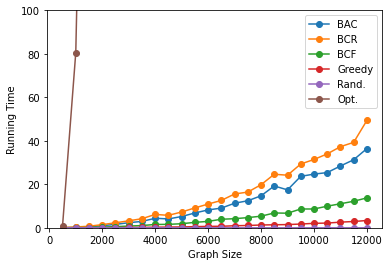

In [3]:
algorithms = [
        (BAC1, "BAC"),
        (BAC2, "BCR"),
        (BAC3, "BCF"),
        (largest_dmin_next, "Greedy"),
        (randomk, "Rand."),
        (optimum_MaxIndSet_binsearch, "Opt."),
    ]
hard_time_limit = 1000
soft_time_limit = 100
data = np.loadtxt('running_times_vs_graph_sizes.txt')
graph_sizes = data[:, 0]
running_times = data[:, 1:]

max_running_time = np.max(running_times)
if hard_time_limit is not None:
    running_times[running_times == np.inf] = hard_time_limit

# Plot the running times for each algorithm
for i, (_, algorithm_name) in enumerate(algorithms):
    plt.plot(graph_sizes, running_times[:, i], label=algorithm_name, marker='o')

plt.xlabel('Graph Size')
plt.ylabel('Running Time')
if soft_time_limit is not None:
    plt.ylim(0, min(max_running_time*1.1, soft_time_limit))
else:
    plt.ylim(0, max_running_time*1.1)
plt.legend()
plt.savefig('running_times_vs_graph_sizes.pdf')
plt.show()

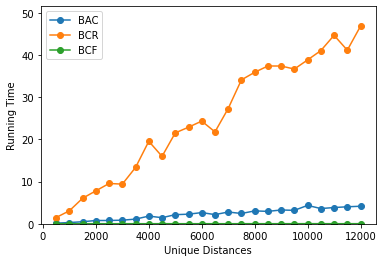

In [4]:
data = np.loadtxt('running_times_vs_unique_distances.txt')
graph_sizes = data[:, 0]
running_times = data[:, 1:]

max_running_time = np.max(running_times)
if hard_time_limit is not None:
    running_times[running_times == np.inf] = hard_time_limit

algorithms = [
    (BAC1, "BAC"),
    (BAC2, "BCR"),
    (BAC3, "BCF"),
]

# Plot the running times for each algorithm
for i, (_, algorithm_name) in enumerate(algorithms):
    plt.plot(graph_sizes, running_times[:, i], label=algorithm_name, marker='o')

plt.xlabel('Unique Distances')
plt.ylabel('Running Time')
if soft_time_limit is not None:
    plt.ylim(0, min(max_running_time*1.1, soft_time_limit))
else:
    plt.ylim(0, max_running_time*1.1)
plt.legend()
plt.savefig('running_times_vs_unique_distances.pdf')
plt.show()

In [5]:
datasets = [ft70, kro124, c_elegans, rbg323, wiki_vote_snap, airport, moreno_health, openflight, cora, bitcoin, gnutella_snap]
#datasets = [ft70, kro124, c_elegans, rbg323, airport, moreno_health, openflight, cora, bitcoin]

optimal_values = {
    "ft70": 786,
    "kro124p": 1136,
    "celegansneural": 7,
    "rbg323": 15,
    "Wiki-Vote": 5,
    "airport": 64036,
    "moreno": 22,
    "openflight": 9,
    "cora": 27,
    "bitcoin": 77,
    "Gnutella": 13,
}

algorithms = [
    (BAC1, "BAC"),
    (BAC2, "BCR"),
    (BAC3, "BCF"),
    (largest_dmin_next, "Greedy"),
    (randomk, "Rand."),
    #(optimum_MaxIndSet_binsearch, "Opt.")
]
k = 10

In [6]:
for dataset in datasets:
    D_weights = read_graph_from_file(dataset)
    print(dataset)
    print(f"size: {D_weights.shape[0]}")
    print(f"dmax: {np.max(np.max(D_weights, axis=0))}")
    np.fill_diagonal(D_weights, np.inf) # exclude diagonal 
    print(f"dmin: {np.min(np.min(D_weights, axis=0))}")
    print(f"unique: {np.unique(D_weights).shape[0]-1}")
    print("**************")

datasets/ALL_atsp/ft70.atsp
size: 70
dmax: 2588.0
dmin: 331.0
unique: 1441
**************
datasets/ALL_atsp/kro124p.atsp
size: 100
dmax: 4309.0
dmin: 81.0
unique: 3297
**************
datasets/weighted_digraphs/celegansneural_weighted.txt
size: 297
dmax: 24.0
dmin: 1.0
unique: 24
**************
datasets/ALL_atsp/rbg323.atsp
size: 323
dmax: 21.0
dmin: 0.0
unique: 22
**************
datasets/weighted_digraphs/Wiki-Vote.txt
size: 1300
dmax: 9.0
dmin: 1.0
unique: 9
**************
datasets/weighted_digraphs/airport.txt
size: 1402
dmax: 169685.0
dmin: 1.0
unique: 27237
**************
datasets/weighted_digraphs/moreno_health_weighted.txt
size: 2155
dmax: 52.0
dmin: 1.0
unique: 52
**************
datasets/weighted_digraphs/openflight.txt
size: 2868
dmax: 17.0
dmin: 1.0
unique: 17
**************
datasets/weighted_digraphs/cora.txt
size: 3991
dmax: 45.0
dmin: 1.0
unique: 45
**************
datasets/weighted_digraphs/bitcoin.txt
size: 4709
dmax: 134.0
dmin: 0.0
unique: 130
**************
datasets/wei

In [7]:
add_optimals_manually = not "Opt." in [name for _, name in algorithms]

results_filename = "performance_results.txt"
verbose = True

#with open(results_filename, "w+") as f:
#    test_all_datasets(datasets, algorithms, k, results_file=f, verbose=verbose)
    
results, algorithm_names = read_results_file(results_filename, add_optimals_manually=add_optimals_manually, optimal_values=optimal_values)
latex_table_scores = create_latex_table_scores(results, algorithm_names)
latex_table_percentages = create_latex_table_score_percentages(results, algorithm_names)
if add_optimals_manually:
    latex_table_times = create_latex_table_times(results, algorithm_names[:-1])
else:
    latex_table_times = create_latex_table_times(results, algorithm_names)
    
display(Latex(latex_table_to_mathjax(latex_table_scores)))
display(Latex(latex_table_to_mathjax(latex_table_percentages)))
display(Latex(latex_table_to_mathjax(latex_table_times)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
print(latex_table_scores)
print()
print(latex_table_percentages)
print()
print(latex_table_times)

\begin{table}[] \centering
\tcbset{colframe=black!5, colback=black!5, size=fbox, on line}
\begin{tabular}{@{}lrrrrrr@{}}\toprule
Data & BAC & BCR & BCF & Greedy & Rand. & Opt. \\
\midrule
\emph{ft70} & 745 & \tcbox{768} & 745 & 745 & 494 & 786 \\
\emph{kro124p} & 994 & \tcbox{1 008} & 994 & 994 & 509 & 1 136 \\
\emph{celegansneural} & \tcbox{7} & \tcbox{7} & \tcbox{7} & \tcbox{7} & 2 & 7 \\
\emph{rbg323} & 12 & \tcbox{15} & 12 & 12 & 0 & 15 \\
\emph{Wiki-Vote} & \tcbox{4} & \tcbox{4} & \tcbox{4} & \tcbox{4} & 2 & 5 \\
\emph{airport} & \tcbox{64 036} & \tcbox{64 036} & \tcbox{64 036} & \tcbox{64 036} & 5 & 64 036 \\
\emph{moreno} & \tcbox{22} & \tcbox{22} & \tcbox{22} & \tcbox{22} & 6 & 22 \\
\emph{openflight} & \tcbox{9} & \tcbox{9} & \tcbox{9} & \tcbox{9} & 3 & 9 \\
\emph{cora} & \tcbox{27} & \tcbox{27} & \tcbox{27} & \tcbox{27} & 5 & 27 \\
\emph{bitcoin} & \tcbox{77} & \tcbox{77} & \tcbox{77} & \tcbox{77} & 22 & 77 \\
\emph{Gnutella} & 11 & \tcbox{12} & 11 & 11 & 5 & 13 \\
\bottomrul

In [9]:
D_weights = read_graph_from_file(gnutella_snap)
R = 13
D_min_weights = np.minimum(D_weights, D_weights.T)
Gr = nx.Graph()
Gr.add_nodes_from(range(D_weights.shape[0]))
x, y = np.nonzero(D_min_weights >= R)
Gr.add_edges_from(zip(x, y))
clique = nx.max_weight_clique(Gr, weight=None)[0]
len(clique)

10